# Parallelization

In [18]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

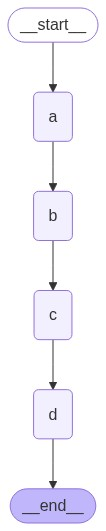

In [1]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

#### Let's run `b` and `c` in parallel

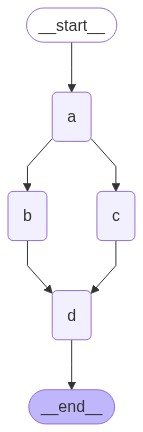

In [3]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

We get an error because both `b` and `c` are writing to the ***same key/channel*** in the ***same step***

In [4]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


When using fan-out we need to be sure of the reducer

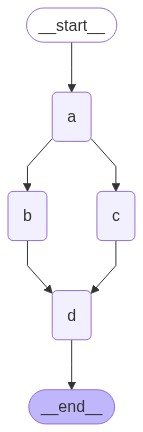

In [5]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

## Waiting for Nodes to Finish
Let's consider a case when one parallel path has multiple steps

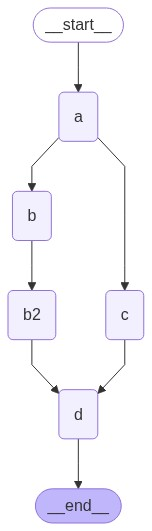

In [7]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In this case, `b`, `b2`, and `c` are all part of the same step.

The graph will wait for all of these to be completed before proceeding to step `d`. 

In [8]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## Setting the Order of State Updates

- Order of updates : Deterministic but not in our control
- Solution: Use a custom reducer that operates on the state updates to our liking

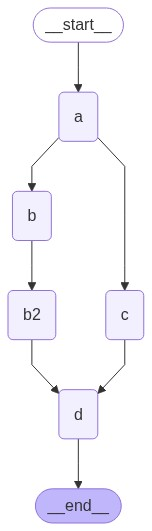

In [9]:
def sorting_reducer(left, right):
    """Combines and Sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right,list):
        right = [right]
    
    return sorted(left+right, reverse=False)

class State(TypedDict):
    state: Annotated[list, sorting_reducer]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

`sorting_reducer` sorts all the values ***globally***
We can also:
1. Write outputs to a separate field during parallel steps
2. Use a `Sink` node after the parallel steps to combine and order the outputs
3. Clear the temporary field after combining

# Working with LLMs

- We want to gather context from two external sources (Wikipedia and Web-Seach) and have an LLM answer a question.

In [14]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [15]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list,operator.add]

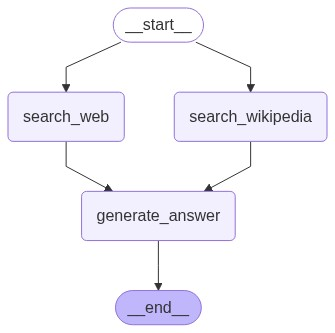

In [16]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content

"Nvidia's Q2 2024 earnings were very strong. The company reported record revenue of $30.0 billion, which was up 15% from the previous quarter and up 122% from a year ago. The GAAP earnings per diluted share were $0.67, up 12% from the previous quarter and up 168% from a year ago, while the non-GAAP earnings per diluted share were $0.68, up 11% from the previous quarter and up 152% from a year ago. Nvidia's data center division also delivered a strong performance with record revenue of $26.3 billion, up 16% from the previous quarter and up 154% from a year ago. Additionally, Nvidia announced a massive new $50 billion stock buyback program."

# Using LangGraph API

In [25]:
from langgraph_sdk import get_client
client = get_client(url= "http://127.0.0.1:2024")

In [27]:
assistants = await client.assistants.search()
assistants

[{'assistant_id': '4fa68834-b850-5590-9ef4-03f78cac5999',
  'graph_id': 'research_assistant',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'research_assistant',
  'created_at': '2025-06-22T19:20:05.061629+00:00',
  'updated_at': '2025-06-22T19:20:05.061629+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '01914b9c-2e77-57a1-bbc3-9f3db62c1c8d',
  'graph_id': 'map_reduce',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'map_reduce',
  'created_at': '2025-06-22T19:20:05.016663+00:00',
  'updated_at': '2025-06-22T19:20:05.016663+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '536dcacf-12a7-5c20-824d-58bc3204bf7a',
  'graph_id': 'sub_graphs',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'sub_graphs',
  'created_at': '2025-06-22T19:20:04.987823+00:00',
  'updated_at': '2025-06-22T19:20:04.987823+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '5ad5db42-a666-551b-b7a7-df27232253b

In [33]:
# Initialize a thread
thread = await client.threads.create()
input_question = {"question": "How were Nvidia Q2 2024 earnings?"}
# Stream
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="parallelization", 
                                      input=input_question, 
                                      stream_mode="values"):
    # Check if answer has been added to state  
    print(event)

StreamPart(event='metadata', data={'run_id': '1f04f9ee-fc91-6e89-82af-2ee085cdc7c4', 'attempt': 1})
StreamPart(event='values', data={'question': 'How were Nvidia Q2 2024 earnings?', 'context': []})
StreamPart(event='', data=None)
StreamPart(event='values', data={'question': 'How were Nvidia Q2 2024 earnings?', 'context': ['<Document href="https://investor.nvidia.com/news/press-release-details/2024/NVIDIA-Announces-Financial-Results-for-Second-Quarter-Fiscal-2025/default.aspx"/>\nSANTA CLARA, Calif., Aug. 28, 2024 (GLOBE NEWSWIRE) -- NVIDIA (NASDAQ: NVDA) today reported revenue for the second quarter ended July 28, 2024, of $30.0 billion, up 15% from the previous quarter and up 122% from a year ago.\n\nFor the quarter, GAAP earnings per diluted share was $0.67, up 12% from the previous quarter and up 168% from a year ago. Non-GAAP earnings per diluted share was $0.68, up 11% from the previous quarter and up 152% from a year ago. [...] [View all news](https://nvidianews.nvidia.com/)\n\n#